In [1]:
!pip install pytorch-msssim torchdiffeq

In [27]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.distributions import Normal
from pytorch_msssim import ssim
from torchdiffeq import odeint
import math
import time
import pickle

In [18]:
def get_coord_grid(H, W):
    """
    Returns a tensor of shape (H*W, 2) with normalized (x, y) coordinates
    in the range [-1, 1].
    """
    y = torch.linspace(-1, 1, steps=H)
    x = torch.linspace(-1, 1, steps=W)
    yy, xx = torch.meshgrid(y, x, indexing="ij")
    coords = torch.stack([xx, yy], dim=-1)  # (H, W, 2)
    coords = coords.reshape(-1, 2)          # (H*W, 2)
    return coords

# MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),  # (H,W) in [0,1]
])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Define target image
H, W = 28, 28
coords = get_coord_grid(H, W)

In [19]:
# --------------------------
# RuleNet
# --------------------------
class RuleNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.hidden_dim = hidden_dim

    def forward(self, x, weights):
        """
        coords: (B, N, 2)
        weights: list of [W1, b1, W2, b2, W3, b3]
        """
        W1, b1, W2, b2, W3, b3 = weights

        h1 = torch.bmm(x, W1.transpose(1,2)) + b1
        h1 = torch.sin(h1)

        # Layer 2: (B, N, 16)
        h2 = torch.bmm(h1, W2.transpose(1,2)) + b2
        h2 = torch.sin(h2)

        # Layer 3: (B, N, 1)
        out = torch.bmm(h2, W3.transpose(1,2)) + b3
        out = torch.sigmoid(out)
        return out  # (B, N, 1)


# --------------------------
# HyperNet (AE)
# --------------------------
class HyperNetAE(nn.Module):
    def __init__(self, img_dim=28*28, hidden_dim=256, latent_dim=32, rule_dims=[(8,16),(16,16),(16,1)]):
        super().__init__()
        self.img_dim = img_dim
        self.latent_dim = latent_dim
        self.rule_dims = rule_dims

        # Encoder
        self.C1 = nn.utils.spectral_norm(nn.Conv2d(1, 32, 4, 2, 1))
        self.C2 = nn.utils.spectral_norm(nn.Conv2d(32, 32, 4, 2, 1))
        self.C3 = nn.utils.spectral_norm(nn.Conv2d(32, latent_dim, 4, 2, 1))
        self.L3 = nn.LayerNorm((latent_dim))

        # Decoder (maps z → all RuleNet weights flattened)
        total_weights = sum(in_d*out_d + out_d for in_d, out_d in rule_dims)
        self.dec_fc1 = nn.utils.spectral_norm(nn.Linear(latent_dim, hidden_dim))
        self.dec_fc2 = nn.utils.spectral_norm(nn.Linear(hidden_dim, total_weights))

    def encode(self, x, training=True):
        h = F.leaky_relu(self.C1(x))
        h = F.leaky_relu(self.C2(h))
        z = self.C3(h).mean(dim=(2, 3))
        #z = self.L3(z)
        if training:
          z = z + torch.randn_like(z) * 0.1
          z = F.dropout(z, p=0.1, training=True)
        return z

    def decode(self, z):

        h = torch.relu(self.dec_fc1(z))
        flat_weights = self.dec_fc2(h)

        # Split into RuleNet weight matrices/biases
        weights = []
        idx = 0
        for in_d, out_d in self.rule_dims:
            W_size = in_d * out_d
            b_size = out_d

            W = flat_weights[:, idx:idx+W_size].view(-1, out_d, in_d)
            idx += W_size
            b = flat_weights[:, idx:idx+b_size].view(-1, 1, out_d)
            idx += b_size

            weights.extend([W.squeeze(0), b.squeeze(0)])

        return weights

    def forward(self, imgs, training=True):
        """
        imgs: (batch, 1, 28, 28)
        """
        z = self.encode(imgs, training)
        weights = self.decode(z)
        return weights, z


class EnergyModel(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(latent_dim, 64)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(64, 64)),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, z): return self.net(z).squeeze(-1)



cuda True
Epoch: 0/10 Iteration 0 Loss:471.9629 8.7617


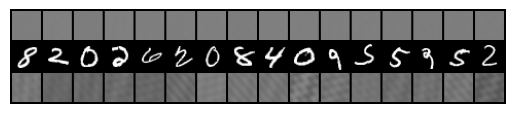

Epoch: 0/10 Iteration 100 Loss:132.9261 -9.0097


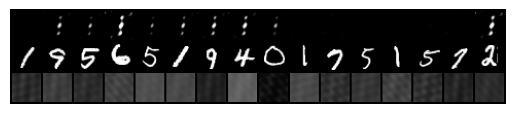

Epoch: 0/10 Iteration 200 Loss:128.0733 -14.0987


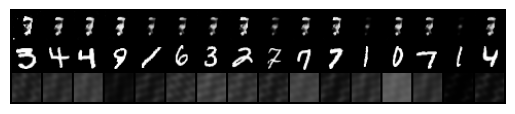

Epoch: 0/10 Iteration 300 Loss:123.4699 -13.6527


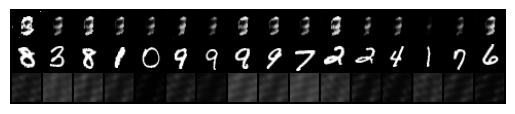

Epoch: 0/10 Iteration 400 Loss:117.5888 -12.2828


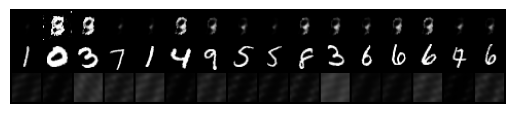

Epoch: 1/10 Iteration 0 Loss:116.8736 -11.0133


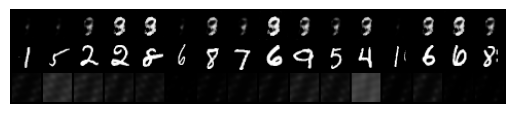

Epoch: 1/10 Iteration 100 Loss:120.1985 -9.0633


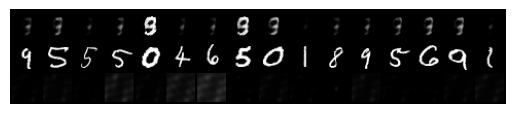

Epoch: 1/10 Iteration 200 Loss:114.0615 -7.835


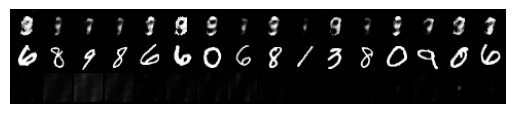

Epoch: 1/10 Iteration 300 Loss:112.1168 -8.1394


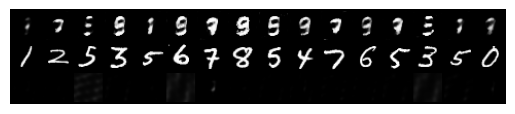

Epoch: 1/10 Iteration 400 Loss:105.5202 -7.1915


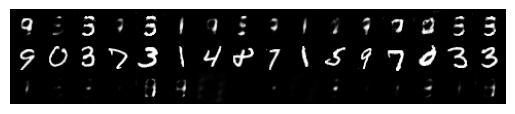

Epoch: 2/10 Iteration 0 Loss:108.353 -6.7501


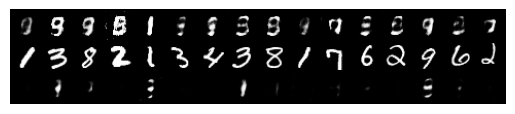

Epoch: 2/10 Iteration 100 Loss:108.5026 -5.8411


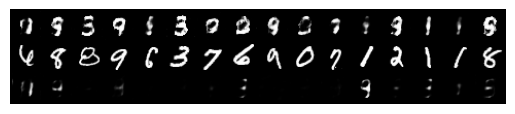

Epoch: 2/10 Iteration 200 Loss:99.4825 -5.9065


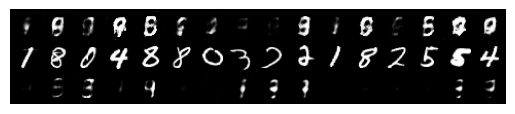

Epoch: 2/10 Iteration 300 Loss:100.7178 -4.5009


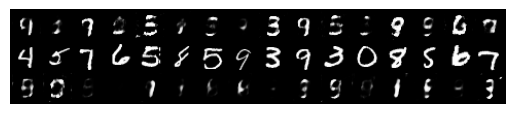

Epoch: 2/10 Iteration 400 Loss:89.6813 -3.96


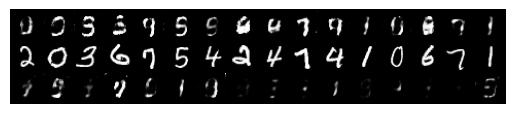

Epoch: 3/10 Iteration 0 Loss:89.2727 -3.4844


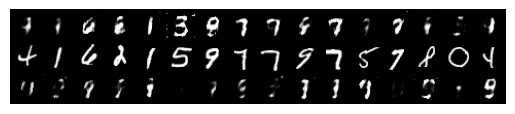

Epoch: 3/10 Iteration 100 Loss:86.8994 -3.4428


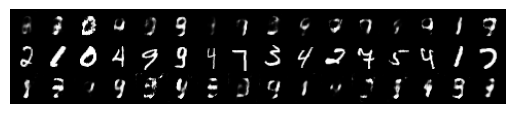

Epoch: 3/10 Iteration 200 Loss:87.1982 -2.6121


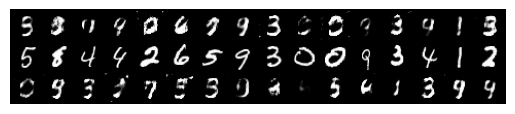

Epoch: 3/10 Iteration 300 Loss:86.1164 -2.923


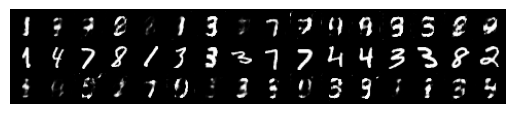

Epoch: 3/10 Iteration 400 Loss:86.3761 -2.6812


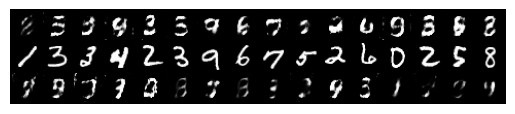

Epoch: 4/10 Iteration 0 Loss:85.187 -1.9328


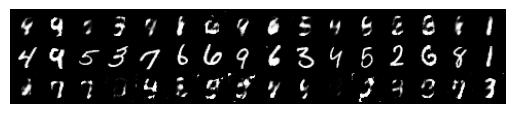

Epoch: 4/10 Iteration 100 Loss:83.6549 -2.1343


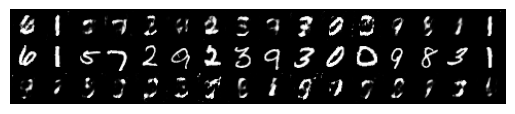

Epoch: 4/10 Iteration 200 Loss:80.7513 -1.4235


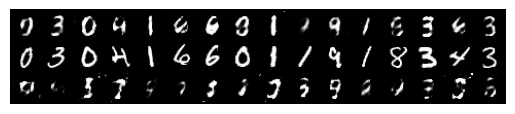

Epoch: 4/10 Iteration 300 Loss:79.1622 -1.1356


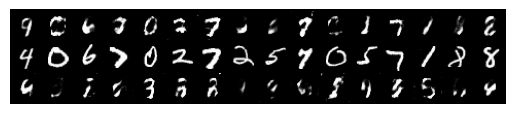

Epoch: 4/10 Iteration 400 Loss:77.0698 -0.8114


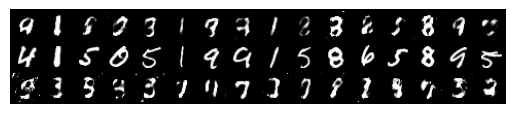

Epoch: 5/10 Iteration 0 Loss:79.329 -0.3119


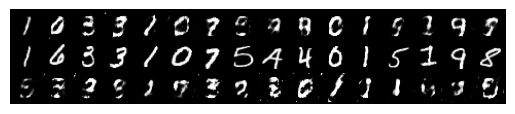

Epoch: 5/10 Iteration 100 Loss:78.6625 -0.2772


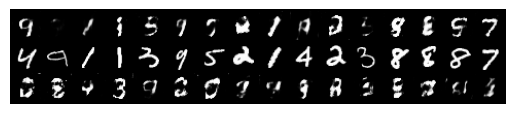

Epoch: 5/10 Iteration 200 Loss:76.3946 -0.3615


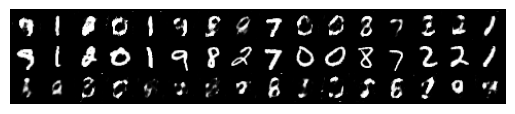

Epoch: 5/10 Iteration 300 Loss:81.1044 0.1281


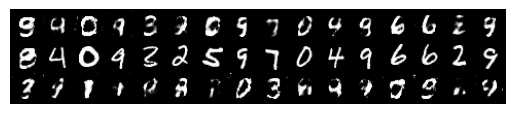

Epoch: 5/10 Iteration 400 Loss:75.7353 -0.1047


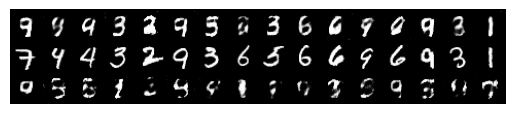

Epoch: 6/10 Iteration 0 Loss:76.1831 0.0801


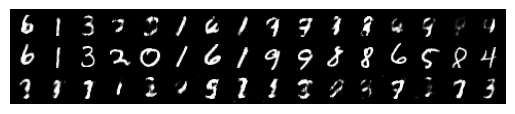

Epoch: 6/10 Iteration 100 Loss:73.7372 -0.5005


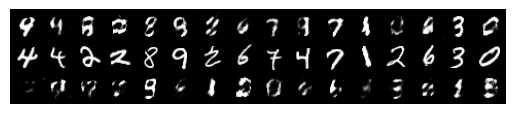

Epoch: 6/10 Iteration 200 Loss:72.8039 -0.6958


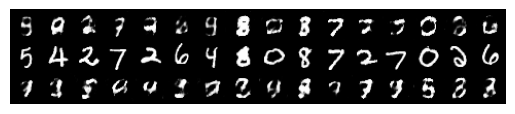

Epoch: 6/10 Iteration 300 Loss:74.8197 -0.5042


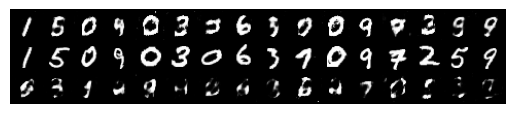

Epoch: 6/10 Iteration 400 Loss:70.6932 -0.446


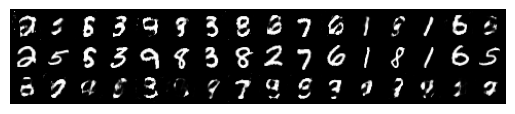

Epoch: 7/10 Iteration 0 Loss:73.4811 -0.2051


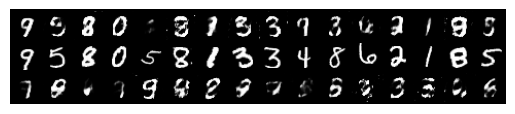

Epoch: 7/10 Iteration 100 Loss:74.6447 -0.2835


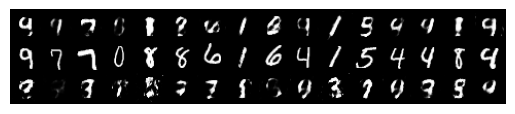

Epoch: 7/10 Iteration 200 Loss:73.4391 -0.0931


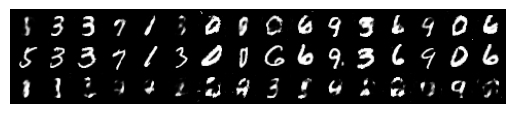

Epoch: 7/10 Iteration 300 Loss:71.1862 -0.5038


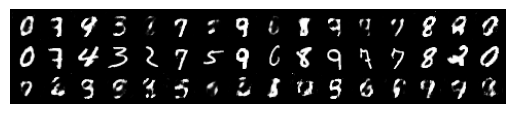

Epoch: 7/10 Iteration 400 Loss:69.5459 0.0126


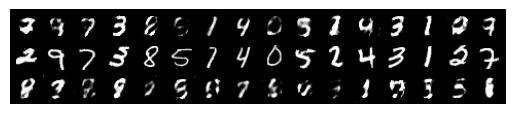

Epoch: 8/10 Iteration 0 Loss:71.5984 -0.2488


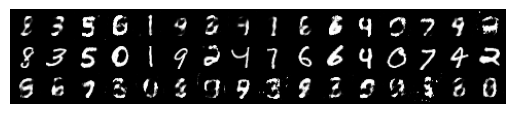

Epoch: 8/10 Iteration 100 Loss:72.2125 -0.237


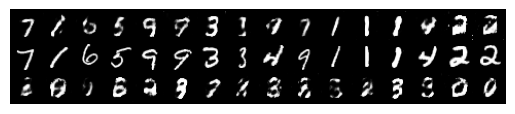

Epoch: 8/10 Iteration 200 Loss:77.1907 -0.2764


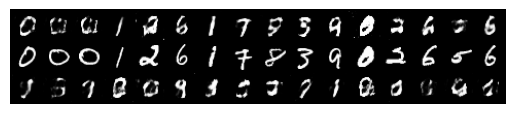

Epoch: 8/10 Iteration 300 Loss:68.8117 -0.3318


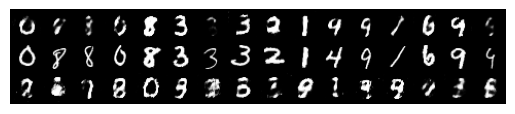

Epoch: 8/10 Iteration 400 Loss:67.765 0.1011


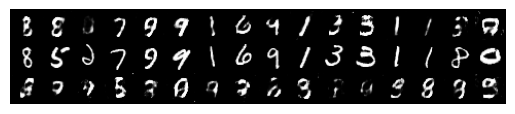

Epoch: 9/10 Iteration 0 Loss:71.0368 -0.122


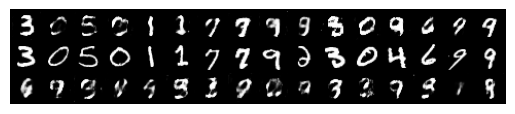

Epoch: 9/10 Iteration 100 Loss:72.3656 -0.1167


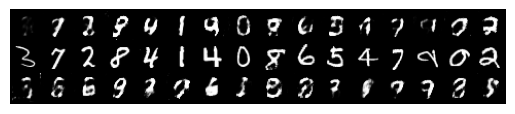

Epoch: 9/10 Iteration 200 Loss:67.9048 -0.0315


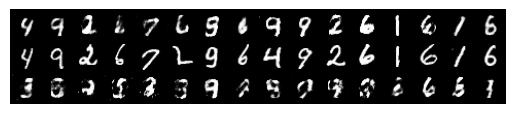

Epoch: 9/10 Iteration 300 Loss:65.922 -0.0054


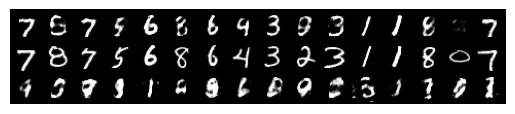

Epoch: 9/10 Iteration 400 Loss:69.9955 0.1628


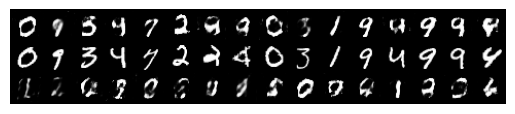

In [37]:
device = torch.device("cuda")
print(device, torch.cuda.is_available())

hypernetG = HyperNetAE().to(device)
rulenet = RuleNet().to(device)
energy_model = EnergyModel().to(device)

optG = torch.optim.Adam(hypernetG.parameters(), lr=1e-3)
optE = torch.optim.Adam(energy_model.parameters(), lr=1e-3)
epochs = 10

B = torch.randn(4, 2).to(device)
x_proj = 2 * torch.pi * coords.to(device) @ B.T
x_proj = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# Persistent buffer
neg_buffer = torch.randn(2000, 32, device=device)

# EBM energy function
def energy_function(z):
    return energy_model(z).sum(dim=-1)

# ODE dynamics
def ode_dynamics(t, z):
    z = z.requires_grad_(True)
    grad = torch.autograd.grad(energy_function(z).sum(), z, create_graph=True)[0]
    return -grad * 0.1  # scale for stability


for epoch in range(epochs):
    for k, (imgs, _) in enumerate(train_loader):
        #coords_ = coords.view(1, -1, 2).repeat(imgs.shape[0], 1, 1)
        imgs = imgs.to(device)
        x_proj_ = x_proj.view(1, 784, 8).repeat(imgs.shape[0], 1, 1)
        #x_proj_ += 0.01*torch.randn_like(x_proj_)

        # HyperNet → weights
        weights, z_enc = hypernetG(imgs, training=True)
        # RuleNet forward
        out_flat = rulenet(x_proj_, weights)  # (batch, N, 1)
        out_img = out_flat.view(-1, 1, 28, 28)

        g_loss = 0.01*F.l1_loss(out_img, imgs, reduction="sum") + (1 - ssim(out_img, imgs, data_range=1, size_average=True)) \

        optG.zero_grad()
        g_loss.backward()
        optG.step()

        # === Train Energy Model ===
        with torch.no_grad():
            _, z_pos = hypernetG(imgs, training=True)
        z_pos.requires_grad = True

        # Sample negatives from buffer
        neg_indices = torch.randint(0, 2000, size=(z_pos.shape[0],))
        z_neg = neg_buffer[neg_indices].clone().detach()

        # ODE integration
        t_points = torch.linspace(0., 1., steps=5, device=device)
        z_neg = odeint(ode_dynamics, z_neg.requires_grad_(True), t_points, method="rk4")[-1]

        # Update buffer
        neg_buffer[neg_indices] = z_neg.detach()

        # --- Negative energy ---
        E_pos = energy_model(z_pos)
        E_neg = energy_model(z_neg)

        # --- Contrastive divergence loss ---
        energy_loss = (E_pos.mean() - E_neg.mean())

        # Gradient penalty on real latents
        grad_outputs = torch.ones_like(E_pos)
        grads = torch.autograd.grad(
            outputs=E_pos, inputs=z_pos,
            grad_outputs=grad_outputs,
            create_graph=True, retain_graph=True
        )[0]
        gp = ((grads.norm(2, dim=1) - 1)**2).mean()
        energy_loss = energy_loss + 10 * gp

        optE.zero_grad()
        energy_loss.backward()
        optE.step()


        if k % 100 == 0:
          print(f"Epoch: {epoch}/{epochs} Iteration {k} Loss:{round(g_loss.item(), 4)} {round(energy_loss.item(), 4)}")

          neg_indices = torch.randint(0, 2000, size=(z_pos.shape[0],))
          z_neg = neg_buffer[neg_indices].clone().detach()

          with torch.no_grad():
            x_proj_ = x_proj.view(1, 784, 8).repeat(z_neg.shape[0], 1, 1)
            weights = hypernetG.decode(z_neg)
            # RuleNet forward
            gen_flat = rulenet(x_proj_, weights)  # (batch, N, 1)
            gen_imgs = gen_flat.view(-1, 1, 28, 28)

          combined = torch.cat([out_img[:16].cpu(), imgs[:16].cpu(), gen_imgs[:16].cpu()], dim=0)
          grid = make_grid(combined, nrow=16)
          grid = grid.numpy().transpose(1, 2, 0)
          plt.imshow(grid)
          plt.axis('off')
          plt.show()

